In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np

class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(784, 100, bias=False)
        self.linear2 = nn.Linear(100, 200, bias=False)
        self.linear3 = nn.Linear(200, 10, bias=False)

    def forward(self, x, scale_list):
        
        self.linear1.weight.data = torch.clamp(self.linear1.weight.data, -1, 1)
        # self.linear1.bias.data = torch.clamp(self.linear1.bias.data, -1, 1)
        out = self.linear1(x)
        out = out*scale_list[0]
        out = torch.tanh(out)

        self.linear2.weight.data = torch.clamp(self.linear2.weight.data, -1, 1)
        # self.linear2.bias.data = torch.clamp(self.linear2.bias.data, -1, 1)
        out = self.linear2(out)
        out = out*scale_list[1]
        out = torch.tanh(out)

        self.linear3.weight.data = torch.clamp(self.linear3.weight.data, -1, 1)
        # self.linear3.bias.data = torch.clamp(self.linear3.bias.data, -1, 1)
        out = self.linear3(out)
        out = out*scale_list[2]
        out = torch.tanh(out)

        return out

In [2]:
# Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Create model
model = FCNN().to(device)
# load model
# model.load_state_dict(torch.load('data/FCNN_MNIST.pt'))

# Set loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load MNIST dataset, split train and test
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = dsets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = dsets.MNIST(root='../data', train=False, transform=transform)

# train loader, test loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# check the min and max in dataloader
for i, (images, labels) in enumerate(train_loader):
    print(torch.min(images), torch.max(images))
    break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

tensor(0.) tensor(1.)


In [ ]:
# Train the model
acc_max = 0
loss_min = 999
for epoch in range(100):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 784).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images, [1,1,1])
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print('TRAIN: Epoch: {}, Loss: {:.4f}'.format(epoch + 1, loss.item()))

    # test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(-1, 784).to(device)
            labels = labels.to(device)
            outputs = model(images, [1,1,1])
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # save best model, both accuracy and loss
        if (acc_max < 100 * correct / total) and (loss_min > loss.item()):
            acc_max = 100 * correct / total
            loss_min = loss.item()
            torch.save(model.state_dict(), 'data/FCNN_MNIST.pt')
            print('saved at Epoch: {}, Accuracy: {:.2f}%, loss: {}'
                  .format(epoch + 1, 100 * correct / total, loss.item()))
            #Accuracy: 97.53%, loss: 0.7966966032981873

[[-1.         1.        -1.        -1.        -1.        -1.
  -1.        -1.        -0.9999996 -1.       ]]


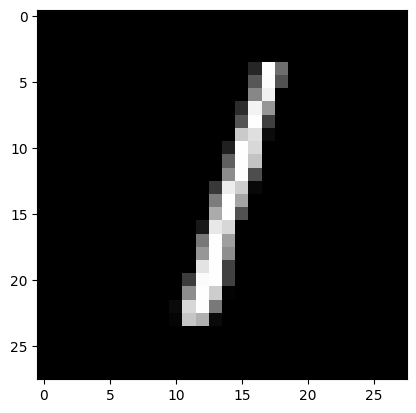

In [8]:

model2 = FCNN()
model2.load_state_dict(torch.load('data/FCNN_MNIST.pt'))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

for i, (images, labels) in enumerate(test_loader):
    if i == 2:
        images = images.view(-1, 784)
        outputs = model2(images, [1,1,1])
        print(outputs.detach().numpy())
        # plot images
        plt.imshow(images[0].reshape(28, 28), cmap='gray')
        plt.show()
        break


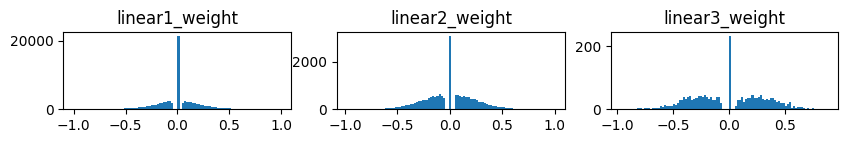

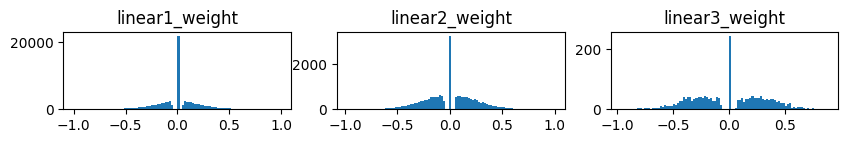

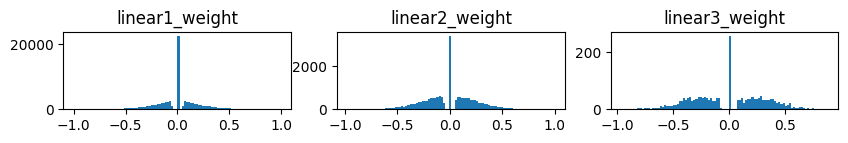

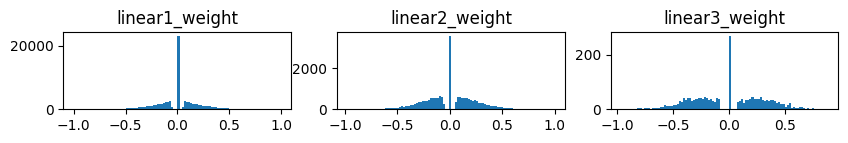

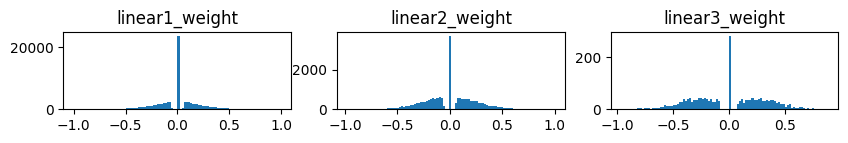

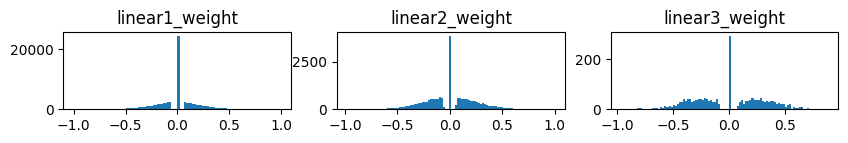

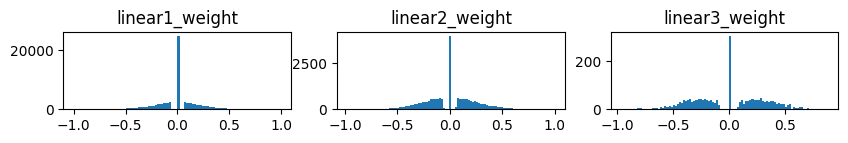

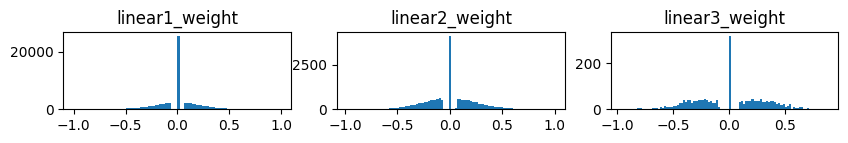

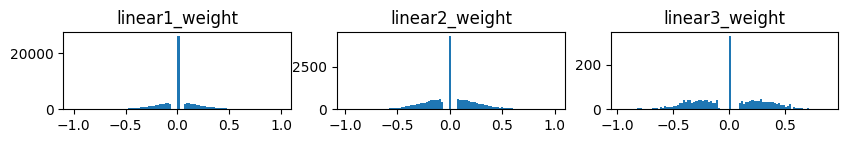

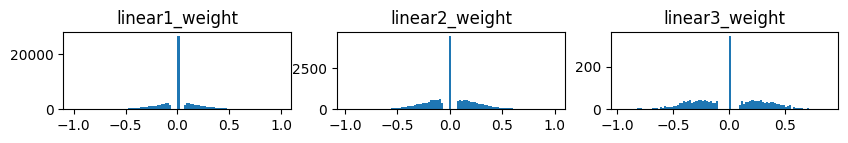

Accuracy of the network on the 10000 test images: 97.8 %


In [9]:
# load dict
model3 = FCNN()
model3.load_state_dict(torch.load('data/FCNN_MNIST.pt'))

# process with the k-th layer's weights
# thres_nr_zo = std(W_k) * (alpha + beta*i)
# if |W_k| < thres_nr_zo, then W_k = 0

linear1_weight = model3.linear1.weight.data
linear2_weight = model3.linear2.weight.data
linear3_weight = model3.linear3.weight.data
# perform thres to linear1_weight and linear1_bias
linear1_weight = linear1_weight.cpu().numpy().reshape(100, 784).flatten()
linear2_weight = linear2_weight.cpu().numpy().reshape(200, 100).flatten()
linear3_weight = linear3_weight.cpu().numpy().reshape(10, 200).flatten()

for i in range(10):
    # calculate std
    std_linear1_weight = np.std(linear1_weight)
    std_linear2_weight = np.std(linear2_weight)
    std_linear3_weight = np.std(linear3_weight)
    # calculate thres
    thres_l1_w = std_linear1_weight * (0.2 + 0.01 * i)
    thres_l2_w = std_linear2_weight * (0.2 + 0.01 * i)
    thres_l3_w = std_linear3_weight * (0.2 + 0.01 * i)
    # perform thres
    linear1_weight[abs(linear1_weight) < thres_l1_w] = 0
    linear2_weight[abs(linear2_weight) < thres_l2_w] = 0
    linear3_weight[abs(linear3_weight) < thres_l3_w] = 0
    # plot hist of linear1_weight123 each iter, in subplots, 1 row 3 cols
    plt.figure(figsize=(10, 1))
    plt.subplot(1, 3, 1)
    plt.hist(linear1_weight, bins=100)
    plt.title('linear1_weight')
    plt.subplot(1, 3, 2)
    plt.hist(linear2_weight, bins=100)
    plt.title('linear2_weight')
    plt.subplot(1, 3, 3)
    plt.hist(linear3_weight, bins=100)
    plt.title('linear3_weight')
    plt.show()


# write the thresed weights to a new model
device = torch.device('cpu')

model4 = FCNN()
model4.load_state_dict(torch.load('data/FCNN_MNIST.pt'))

# write the linear1_weight, linear2_weight, linear3_weight to the model
model4.linear1.weight.data = torch.from_numpy(linear1_weight.reshape(100, 784)).float().to(device)
model4.linear2.weight.data = torch.from_numpy(linear2_weight.reshape(200, 100)).float().to(device)
model4.linear3.weight.data = torch.from_numpy(linear3_weight.reshape(10, 200)).float().to(device)

# test the model
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 784).to(device)
        labels = labels.to(device)
        outputs = model4(images, [1,1,1])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# save the model
torch.save(model4.state_dict(), 'data/FCNN_MNIST_rmvd.pt')

In [10]:
model5 = FCNN()
model5.load_state_dict(torch.load('data/FCNN_MNIST_rmvd.pt'))
# print min and max value for each weight
print(torch.min(model5.linear1.weight.data), torch.max(model5.linear1.weight.data))
print(torch.min(model5.linear2.weight.data), torch.max(model5.linear2.weight.data))
print(torch.min(model5.linear3.weight.data), torch.max(model5.linear3.weight.data))

tensor(-1.) tensor(1.)
tensor(-0.9763) tensor(0.9993)
tensor(-0.9671) tensor(0.8893)


# SC-inference

### SC-tools

In [11]:
# SC tools
# SNG
def SNG_10(seed: int, target: float,
        bitstream_length=1024, bit1=7, bit2=10, isprint=False):

    # check the seed in range (0-1023)
    assert seed > 0 and seed < 1023, "seed should be in range (0-1023)"
    # check the target in range (-1, 1)
    assert target >= -1 and target <= 1, "target should be in range (-1, 1)"
    
    # convert seed to binary
    seed_bin_str = format(seed, '010b')
    seed = np.array([int(i) for i in seed_bin_str])

    # convert target to unipolar
    target = (target + 1) / 2 # (-1, 1) -> (0, 1)
    target_10 = target * 1023

    lfsr = seed.copy()
    output_stream = np.zeros(bitstream_length)

    # do xor on bit1 and bit2
    for i in range(bitstream_length):
        xorbit = lfsr[10-bit1] ^ lfsr[10-bit2]  # xor on bit7 and bit10
        lfsr = np.roll(lfsr, -1)                # shift left
        lfsr[9] = xorbit                        # set xorbit to bit0
        lfsr_val = int(''.join([str(i) for i in lfsr]), 2) # array->binary->int
        if isprint: print(lfsr_val)
        if lfsr_val <= target_10:
            output_stream[i] = 1
        else:
            output_stream[i] = 0

    return output_stream

# generate matrix using SNG
def gen_mat(mat:np.array):
    # for each element in mat, generate a 1024 bitstream
    mat_out = np.zeros((mat.shape[0], mat.shape[1], 2**10))
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            seed = np.random.randint(1, 2**10-1)
            mat_out[i][j] = SNG_10(seed, mat[i][j])

    return mat_out

def ADD_apc(neuron_tmp: np.array):
    # example: neuron_tmp(784, 2**10)
    # count the number of 1 in each column, the count result is the output of APC
    output_stm = np.zeros((2**10))
    for i in range(neuron_tmp.shape[1]):
        output_stm[i] = np.sum(neuron_tmp[:, i])
    return output_stm


def MUL_bip(x1: np.array, x2: np.array):
    assert x1.shape == x2.shape, 'shape not match, multiplying failed'
    return np.where(x1==x2, 1, 0)


def Tanh_for_apc(stm:np.array, opends):

    logg = False
    output_stream = np.zeros(stm.shape[0], dtype=int)
    # create state num by opends
    scale = 1
    qq = 1.835*(2*opends) ** (-0.5552)
    r_ = (2*(1-scale)*(opends-1)) / scale*(1-qq) + 2*(opends)
    # r = nearest multiple of two(r_), 最近的2的倍数
    r = 2 * round(r_/2)
    state_num = r - 1
    state_half = r / 2
    if logg: print('r:{}, r_:{}, qq:{}'.format(r, r_, qq))
    if logg: print('opends', opends,' state num: ', state_num, 'state half: ', state_half)

    # init state
    state = 0
    # read stm
    for i in range(stm.shape[0]):
        V = stm[i] * 2 - opends
        if logg: print('V: ', V)
        state = state + V
        if logg: print('updtd state: ', state)
        if state > state_num:
            state = state_num
        if state < 0:
            state = 0
        
        # output stream
        if state > state_half:
            output_stream[i] = 1
        elif (state <= state_half):
            output_stream[i] = 0
        else: print('output stream error')

    return output_stream
    

def SC_mat_mul(x_mat, w_mat, x_real=0, w_real=0): 
    # example shape: x_mat (1,784), w_mat (100,784), x_real (1,784), w_real (784,100)
    result = np.zeros((x_mat.shape[0], w_mat.shape[0], 2**10))
    assert x_mat.shape[1] == w_mat.shape[1], 'shape not match, multiplying failed'
    for i in range(x_mat.shape[0]):
        for j in range(w_mat.shape[0]):
            # print('output col: {}'.format(j))
            mul_tmp = np.zeros((x_mat.shape[1], 2**10)) # e.g. save 784 results, for APC add
            for k in range(x_mat.shape[1]):
                if (x_real[i, k]==0) or (w_real[j, k]==0):
                    seed = np.random.randint(1, 2**10-1)
                    mul = SNG_10(seed, 0) # no mul
                else:
                    mul = MUL_bip(x_mat[i, k], w_mat[j, k])
                mul_tmp[k] = mul
            # APC add
            mul_tmp_res = ADD_apc(mul_tmp)
            # print('mul_tmp_res: {}'.format(mul_tmp_res)) # [400, 328, ...], shape(2**10,)
            # tanh
            tanh_res = Tanh_for_apc(mul_tmp_res, x_mat.shape[1])
            # print('tanh_res: {}'.format(tanh_res))
            result[i, j] = tanh_res
            print('output col: {}, value {}'.format(j, tanh_res.mean()*2-1))
    
    return result


### make SC weight and x

In [12]:
# read the model
model6 = FCNN()
model6.load_state_dict(torch.load('data/FCNN_MNIST_rmvd.pt'))

# extract the weights
linear1_weight = model6.linear1.weight.data.cpu().numpy()
linear2_weight = model6.linear2.weight.data.cpu().numpy()
linear3_weight = model6.linear3.weight.data.cpu().numpy()

# generate the matrix
SC_linear1_weight = gen_mat(linear1_weight)
SC_linear2_weight = gen_mat(linear2_weight)
SC_linear3_weight = gen_mat(linear3_weight)

# save the matrix
np.save('data/SC_linear1_weight.npy', SC_linear1_weight)
np.save('data/SC_linear2_weight.npy', SC_linear2_weight)
np.save('data/SC_linear3_weight.npy', SC_linear3_weight)

In [14]:
for i in range(5):
    print(linear3_weight[5][i])
    print((SC_linear3_weight[5][i]).mean()*2 -1)
    print('---------------------------------')

0.0
-0.001953125
---------------------------------
0.0
-0.001953125
---------------------------------
0.2590324
0.2578125
---------------------------------
0.0
0.0
---------------------------------
0.15338114
0.15234375
---------------------------------


In [13]:
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# convert test dataset to SC
test_dataset_SC = np.zeros((10, 1, 784, 1024), dtype=np.float32)
for i, (image, _) in enumerate(test_loader):
    if i < 10:
        image = image.view(1, 784)
        image_SC = gen_mat(image.numpy())
        # print(image_SC.shape) # (1, 784, 1024)
        test_dataset_SC[i] = image_SC

# save the SC test dataset
np.save('data/test_dataset_SC.npy', test_dataset_SC) # (100, 1, 784, 1024)

In [21]:
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

for i, (image, _) in enumerate(test_loader):
    if i < 1:
        image = image.view(1, 784)
        image_SC = gen_mat(image.numpy())
        for ii in range(100):
            print(image[0, 28*8+ii])
            print((image_SC[0, 28*8+ii]).mean()*2 -1)
            print('---------------------------------')
        

tensor(0.)
0.0
---------------------------------
tensor(0.)
-0.001953125
---------------------------------
tensor(0.)
0.0
---------------------------------
tensor(0.)
0.0
---------------------------------
tensor(0.)
-0.001953125
---------------------------------
tensor(0.)
-0.001953125
---------------------------------
tensor(0.8706)
0.869140625
---------------------------------
tensor(0.9961)
0.994140625
---------------------------------
tensor(0.9961)
0.994140625
---------------------------------
tensor(0.9961)
0.994140625
---------------------------------
tensor(0.9961)
0.994140625
---------------------------------
tensor(0.9451)
0.943359375
---------------------------------
tensor(0.7765)
0.775390625
---------------------------------
tensor(0.7765)
0.775390625
---------------------------------
tensor(0.7765)
0.775390625
---------------------------------
tensor(0.7765)
0.775390625
---------------------------------
tensor(0.7765)
0.7734375
---------------------------------
tensor(0.7

# test x*W

In [24]:
class FCNN_2(nn.Module):
    def __init__(self):
        super(FCNN_2, self).__init__()
        self.linear1 = nn.Linear(784, 100, bias=False)
        self.linear2 = nn.Linear(100, 200, bias=False)
        self.linear3 = nn.Linear(200, 10, bias=False)

    def forward(self, x, scale_list):
        
        self.linear1.weight.data = torch.clamp(self.linear1.weight.data, -1, 1)
        # self.linear1.bias.data = torch.clamp(self.linear1.bias.data, -1, 1)
        out = self.linear1(x)
        out = out*scale_list[0]
        out = torch.tanh(out)
        l1_res = out

        self.linear2.weight.data = torch.clamp(self.linear2.weight.data, -1, 1)
        # self.linear2.bias.data = torch.clamp(self.linear2.bias.data, -1, 1)
        out = self.linear2(out)
        out = out*scale_list[1]
        out = torch.tanh(out)
        l2_res = out

        self.linear3.weight.data = torch.clamp(self.linear3.weight.data, -1, 1)
        # self.linear3.bias.data = torch.clamp(self.linear3.bias.data, -1, 1)
        out = self.linear3(out)
        out = out*scale_list[2]
        out = torch.tanh(out)

        return out, l1_res, l2_res
    
model3 = FCNN_2()
model3.load_state_dict(torch.load('data/FCNN_MNIST_rmvd.pt'))

test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# prepare SC data
test_dataset_SC = np.load('data/test_dataset_SC.npy')
SC_linear1_weight = np.load('data/SC_linear1_weight.npy')
SC_linear2_weight = np.load('data/SC_linear2_weight.npy')
SC_linear3_weight = np.load('data/SC_linear3_weight.npy')

linear1_weight = model3.linear1.weight.data.cpu().numpy()
linear2_weight = model3.linear2.weight.data.cpu().numpy()
linear3_weight = model3.linear3.weight.data.cpu().numpy()

print(test_dataset_SC.shape)
#############################################

for i, (image, _) in enumerate(test_loader):
    if i == 0:
        output, l1_res, l2_res = model3(image.view(1, 784), [1,1,1])
        output, l1_res, l2_res = output.detach().numpy(), l1_res.detach().numpy(), l2_res.detach().numpy()
        print("l1 out", l1_res)
        print("l2 out", l2_res)
        print("final output", output)
        ####################################################

        # SC
        # SC_mat_mul: (x, w, x_real, w_real)
        sc_l1_res = SC_mat_mul(test_dataset_SC[0], SC_linear1_weight, image.view(1, 784), linear1_weight)
        print('l1 finished **************************************** \n')

        sc_l2_res = SC_mat_mul(sc_l1_res, SC_linear2_weight, l1_res, linear2_weight)
        print('l2 finished **************************************** \n')

        sc_l3_res = SC_mat_mul(sc_l2_res, SC_linear3_weight, l2_res, linear3_weight)

        print(sc_l3_res.shape)

        break


(10, 1, 784, 1024)
l1 out [[-0.99991435  0.9999984  -0.9980962  -0.9879639   0.99943703 -0.99474764
   0.90629554  1.          0.9969077  -0.47084168  0.9993416  -0.99989796
   0.83656436  0.8980746   0.99564147  0.9999957  -0.37122846  0.99974436
   0.23555735  0.90373755  0.99765706 -0.99759024 -0.9977077   0.9998011
   0.95458364 -0.9999994   0.9999979  -0.5955043   0.9999953  -0.99905735
  -0.9841379   0.9999135  -0.99152637  0.99483347  0.9899591   0.97773963
   0.9999994   0.99995023 -0.94515014  0.5495375   0.32157817  0.9999825
   0.9904637   0.8741553   0.999999    0.9249321  -0.9890807   0.9738308
  -0.9992396   0.9933775  -0.23075551  0.9976336   0.96574914 -0.62565714
  -1.         -0.9999995   0.99995613  0.9753589  -0.42160493 -0.9961516
   0.99999815 -0.9999908   0.99972177  0.76699466 -0.9461742  -0.99640125
  -0.943408   -0.9961713  -0.998272    0.9582566  -0.9662562  -0.80588925
   0.99650496  0.99997693  0.9995506  -0.8995155  -0.80676985  0.97309536
  -0.9400254  -0

In [26]:

for i in range(10):
    print(sc_l3_res[0,i].mean()*2-1)

-0.724609375
-0.73828125
-0.806640625
-1.0
-0.783203125
-0.939453125
-0.98046875
0.87109375
-1.0
-1.0
